In [1]:
# Custom function to transform the date in 5 factors dataframe
def to_date(row):
    year = str(row)[:4]
    month = str(row)[4:6]
    day = str(row)[6:]

    return pd.to_datetime('-'.join([year, month, day]))

In [105]:
# Import dependencies
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read the Fama and French factors
factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')
factors['Date'] = factors.Date.apply(to_date)

In [69]:
# Get the historical data of S&P 500 and Microsoft
spy = yf.Ticker("^GSPC", )
spy = spy.history(period="max")

msft = yf.Ticker("MSFT")
msft = msft.history(period="max")

# Reset the index (Date) for merging
spy.reset_index(inplace=True)
msft.reset_index(inplace=True)

# Calculate the return
spy['Market Return'] = spy['Close'].pct_change(1)
msft['Return'] = msft['Close'].pct_change(1)

In [61]:
# Merging the dataframes and remove row that contains Nan values
df = pd.merge(spy[['Date', 'Market Return']], msft[['Date', 'Return']], on='Date')
df = pd.merge(factors, df, on='Date')
df.dropna(inplace=True)
df

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,Market Return,Return
1,1986-03-14,1.03,-0.83,-0.21,0.11,0.31,0.03,0.014409,0.035712
2,1986-03-17,-0.75,0.00,-0.32,0.38,0.05,0.03,-0.007948,0.017250
3,1986-03-18,0.47,0.04,-0.16,-0.07,0.30,0.03,0.004730,-0.025432
4,1986-03-19,-0.17,0.16,-0.06,0.15,0.15,0.03,-0.000763,-0.017390
5,1986-03-20,0.39,-0.11,0.02,0.12,0.12,0.03,0.003990,-0.026547
...,...,...,...,...,...,...,...,...,...
9060,2022-02-22,-1.18,-0.37,0.12,-0.06,0.12,0.00,-0.010143,-0.000729
9061,2022-02-23,-1.96,0.07,1.25,0.00,1.07,0.00,-0.018412,-0.025893
9062,2022-02-24,1.88,0.67,-3.85,-1.74,-1.75,0.00,0.014957,0.051094
9063,2022-02-25,2.23,-0.12,1.20,0.35,-0.19,0.00,0.022373,0.009233


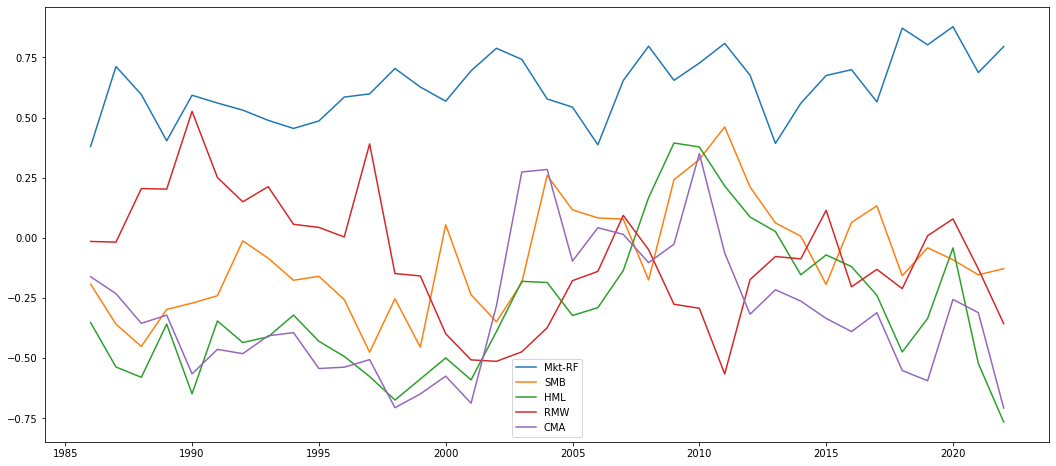

In [162]:
fig, ax = plt.subplots(figsize=(18, 8))
for f in df.columns[1:6]:
    corrs = [(df[df.Date.dt.year == y].set_index('Date')[['Return', f]].corr()['Return'][f], y) for y in df.Date.dt.year.unique()]
    plt.plot([c[1] for c in corrs], [c[0] for c in corrs])
plt.legend([f for f in df.columns[1:6]])
plt.show()

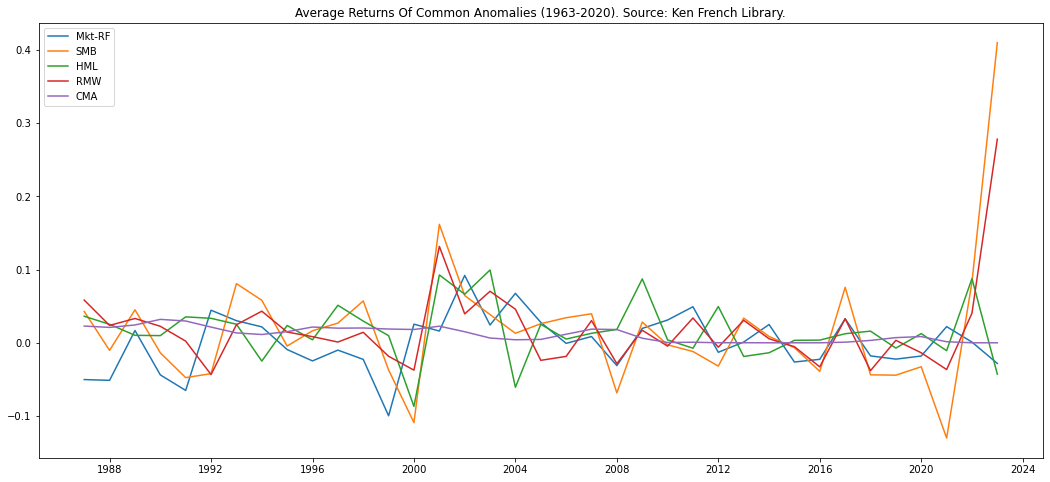

In [161]:
fig, ax = plt.subplots(figsize=(18, 8))
plt.plot(
    df.set_index('Date').resample('1Y').mean().index, 
    df.set_index('Date').resample('1Y').mean().iloc[:, 1:6]
)
plt.title('Average returns of common anomalies (1963-2020). Source: Ken French library.'.title())
plt.legend(df.iloc[:, 1:6].columns)
plt.show()

# CAPM 

> R<sub>i</sub>'(t) = α<sub>i</sub> + β<sub>i</sub>R<sub>M</sub>'(t) + ε<sub>i</sub>(t)
> <br>

where α<sub>i</sub> is the excess return

If α != 0, the security is mispriced If α > 0, the security is underpriced.

In [76]:
# Calculate the risk-free adjusted market return 
df['Adjusted Market Return'] = df['Market Return'] - df['RF']

# Calculate the risk-free adjusted portfolio return 
df['Adjusted Portfolio Return'] = df['Return'] - df['RF']

In [80]:
# Fit data using linear regression
X = df[df.Date.dt.year >= 2017]['Adjusted Market Return']
X = X.to_frame()
X = X.dropna()
X.rename(columns={0:'Return'}, inplace=True)
y = df[df.Date.dt.year >= 2017]['Return']

X = sm.add_constant(X)
lr = sm.OLS(y, X)
res = lr.fit()
res.summary()

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2204.
Date:                Fri, 15 Apr 2022   Prob (F-statistic):          7.22e-282
Time:                        15:54:22   Log-Likelihood:                 4059.9
No. Observations:                1298   AIC:                            -8116.
Df Residuals:                    1296   BIC:                            -8105.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0050      0.000     16.531      0.000       0.004       0.006
Adjusted Market Return     1.0826      0.023     46.947      0.000       1.037       1.128
==============================================================================
Omnibus:                       78.552   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.989
Skew:                           0.206   Prob(JB):                     4.74e-58
Kurtosis:                       5.171   Cond. No.                         78.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R<sup>2</sup> = 0.63 means only 63% of change are explanied.
<br>
Prob (F-statistic) = 7.22e-282 means there is very little chance that the effect of variables is 0.
<br>
Beta of 1.08 suggest that the stock has a higher than average risk.
<br>
The p value of 0.000 for <b>Return</b> is saying there is a 0% chance the <b>Return</b> variable has no affect on the <b>Expected Return</b> are produced by chance.

### Assumptions of CAPM (That's not true):
- Markets are in equilibrium (supply equals demand)
<br>
- Every investor has the same forecasts of returns and risks
<br>
- Every investor is a mean-variance optimizer (holds a combination of tangency portfolio and risk-free asset)
<br>
- Since the tangency portfolio is held by every investors under this model, it becomes the market portfolio